#Tarea 2: Arquitecturas modernas de Redes Neuronales profundas - CNN & UNETs
----

Estudiante: Rafael Contreras

CI: 30391915

## 1. Introduccion

### Notebooks libro UDL


Anexados notebooks del libro del libro UDL

### Informe sobre preguntas practicas

link al informe

### Explicacion de notebooks

#### [Notebook 10.1 - 1D convolution](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_1_1D_Convolution.ipynb)



#### [Notebook 10.2 - Convolution for MNIST-1D](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_2_Convolution_for_MNIST_1D.ipynb)


#### [Notebook 10.3 - 2D convolution](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_3_2D_Convolution.ipynb)

#### [Notebook 10.4 - Downsampling & upsampling](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_4_Downsampling_and_Upsampling.ipynb)

#### [Notebook 10.5 - Convolution for MNIST](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_5_Convolution_For_MNIST.ipynb)

### 1. Experimento

Realizaremos un modelo de clasificacion de imagenes. Usando imagenes de [MNIST 100](https://www.kaggle.com/code/xinhuamurphywang/number-recognition-from-00-to-99/notebook), donde clasificaremos numeros escritos del 00 al 99. Escogimos este dataset porque es similar al usado en el notebook 10.5, aparte de su simplicidad.

Procederemos a hacer leves modificaciones al modelo original para ver como se comporta. Intentaremos reducir el tamano del modelo y facilitar el computo.

In [91]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

#### Datos

Al principio pense en descargar la data y cargarla localmente desde el notebook. Luego al ver que kaggle facilitaba la descarga de esta manera, preferi este metodo.

In [92]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("martininf1n1ty/mnist100")  + '/mnist_compressed.npz'
print(path)

/home/rafael/.cache/kagglehub/datasets/martininf1n1ty/mnist100/versions/1/mnist_compressed.npz


Creamos el dataloader, este genera transformaciones que seran necesarias sobre los datos. Entre ellas tenemos el grayscale, el resize y la transformacion a un tensor.

In [93]:
img_size = 128

class MNIST100Dataset(Dataset):
    def __init__(self, npz_file):
        train_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        data = np.load(npz_file)

        self.images = data['train_images']
        self.labels = data['train_labels']
        self.transform = train_transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        image = self.transform(image)

        return image, label

Aqui dividimos la data en prueba y validacion. Reducimos el batch size y la cantidad de pruebas por batch debido a que queriamos observar el entrenamiento en mas epochs en los graficos siguientes.

In [94]:
dataset = MNIST100Dataset(npz_file=path)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size_train = 10
batch_size_test = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

Esta seccion es para observar las imagenes. Podemos ver las 3 primeras del dataset con sus labels respectivos. Los labels van de 0 a 99.

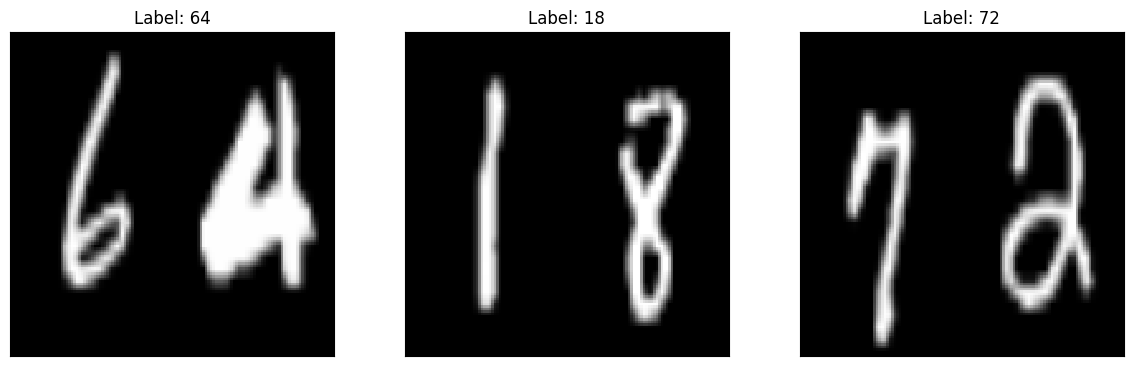

In [95]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.tight_layout()

    image, label = dataset[i]

    if hasattr(image, 'numpy'):
        image = image.numpy()

    # Remove the channel dimension for grayscale display
    image = image.squeeze()

    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Label: {}".format(label))
    plt.xticks([])
    plt.yticks([])

plt.show()

Aqui tenemos la funcion de entrenamiento original modificada ampliamente. Antes esta recibia el epoch id, ahora ella misma ejecuta los epochs dado el argumento num_epochs. Ademas recopila el train history, este es un arreglo por cada epoch donde obtenemos la perdida promedio y la precision.

In [96]:
def train(model, optimizer, num_epochs):
    train_history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        correct = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / len(train_loader.dataset)
        epoch_info = {
            'epoch': epoch,
            'avg_loss': avg_loss,
            'accuracy': accuracy,
        }

        train_history.append(epoch_info)
        print(f'Epoch {epoch}: Avg Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')

    return train_history



Aqui definimos la funcion de prueba. Esta usa el dataset de prueba para evaluar la perdida promedio y la precision del modelo resultante. Es bastante similar a la original del notebook con excepcion de que se le pasa como argumento el modelo.

In [ ]:
# Run on test data
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Esta funcion nos permite hacer un grafico del historial de entrenamiento. Por ahora esta es la grafica que mas nos interesa. Queremos observar que tan rapido aprenden nuestros modelos (numero de epochs) y comparar esto con el tamaño de los mismos.

In [97]:
def plot_training_history(training_history):
    epochs = [info['epoch'] for info in training_history]
    avg_losses = [info['avg_loss'] for info in training_history]
    accuracies = [info['accuracy'] for info in training_history]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_losses, 'b-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'r-', label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Model v1 - Original

Este es el modelo original del notebook.

Epoch 1: Avg Loss: 0.939776, Accuracy: 74.58%
Epoch 2: Avg Loss: 0.187058, Accuracy: 94.28%
Epoch 3: Avg Loss: 0.106792, Accuracy: 96.62%
Epoch 4: Avg Loss: 0.071956, Accuracy: 97.67%
Epoch 5: Avg Loss: 0.046665, Accuracy: 98.49%
Epoch 6: Avg Loss: 0.033576, Accuracy: 98.88%
Epoch 7: Avg Loss: 0.023891, Accuracy: 99.23%
Epoch 8: Avg Loss: 0.021592, Accuracy: 99.32%
Epoch 9: Avg Loss: 0.016790, Accuracy: 99.41%
Epoch 10: Avg Loss: 0.015201, Accuracy: 99.50%


/home/rafael/Desktop/ucv/DL/venv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1851, Accuracy: 11552/12000 (96%)



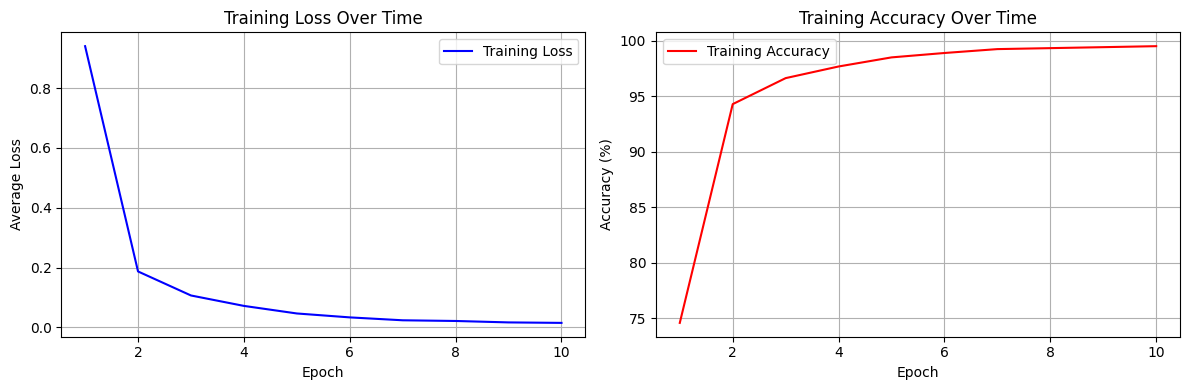

In [98]:
class MNIST100Model(nn.Module):
    def __init__(self, img_width,img_height):
        super(MNIST100Model, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(10, 20, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(16820,50),
          nn.ReLU(),
          nn.Linear(50,100),
          nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = MNIST100Model(img_size,img_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

t_history = train(model,optimizer,10)
test(model)
plot_training_history(t_history)

#### Model v2

In [101]:
class MNIST100Model(nn.Module):
    def __init__(self, img_width,img_height):
        super(MNIST100Model, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(38440,50),
          nn.ReLU(),
          nn.Linear(50,100),
          nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = MNIST100Model(img_size,img_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

t_history = train(model,optimizer,10)
test(model)
plot_training_history(t_history)

Epoch 1: Avg Loss: 1.770114, Accuracy: 52.50%
Epoch 2: Avg Loss: 0.686322, Accuracy: 79.84%
Epoch 3: Avg Loss: 0.388628, Accuracy: 88.46%
Epoch 4: Avg Loss: 0.271407, Accuracy: 91.65%
Epoch 5: Avg Loss: 0.207191, Accuracy: 93.55%
Epoch 6: Avg Loss: 0.161924, Accuracy: 94.76%


KeyboardInterrupt: 

In [ ]:
# Run network on data we got before and show predictions
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Evaluacion

### III-A. CNN

#### 1. Considere la siguiente matriz de entrada $X$:


$$
X = \begin{bmatrix}
2 & 5 & 4 & 1 \\
3 & 1 & 2 & 0 \\
4 & 5 & 7 & 1 \\
1 & 2 & 3 & 4
\end{bmatrix}
$$


##### a) Calcule la salida de una convolución con un kernel $K$ de dimensión $2 \times 2$, sin *padding* y con un *stride* de 2.



$$
K = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

RESPUESTA:

$$
\begin{align*}
res_{0,0} &= 2 * 1 + 5 * 0 + 3 * 0 + 1 * 1 = 3
\\
res_{0,1} &= 4 * 1 + 1 * 0 + 2 * 0 + 0 * 1 = 4
\\
res_{1,0} &= 4 * 1 + 5 * 0 + 1 * 0 + 2 * 1 = 6
\\
res_{1,1} &= 7 * 1 + 1 * 0 + 3 * 0 + 4 * 1 = 11
\\
\end{align*}
\\\\
Res = \begin{bmatrix}
3 & 4 \\
6 & 11
\end{bmatrix}
$$

##### b) Calcule la salida de una convolución con un kernel $K$ de dimensión $2 \times 2$, con *padding* de 2 y con un *stride* de 2.


$$
K = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

Con un padding de 2 la matriz a la que le realizariamos la convolucion seria:

$$
X = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 2 & 5 & 4 & 1 & 0 & 0 \\
0 & 0 & 3 & 1 & 2 & 0 & 0 & 0 \\
0 & 0 & 4 & 5 & 7 & 1 & 0 & 0 \\
0 & 0 & 1 & 2 & 3 & 4 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

$$
\begin{align*}
\begin{array}{ll}
res_{0,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{0,1} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{0,2} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{0,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{1,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{1,1} &= 2 * 1 + 5 * 0 + 3 * 0 + 1 * (-1) = 1 \\
res_{1,2} &= 4 * 1 + 1 * 0 + 2 * 0 + 0 * (-1) = 4 &
res_{1,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{2,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{2,1} &= 4 * 1 + 5 * 0 + 1 * 0 + 2 * (-1) = 2 \\
res_{2,2} &= 7 * 1 + 1 * 0 + 3 * 0 + 4 * (-1) = 3 &
res_{2,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{3,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{3,1} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{3,2} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{3,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0
\end{array}
\end{align*}
$$

$$
\text{Res} = \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 4 & 0 \\
0 & 2 & 3 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

#### 2. ¿Cómo podemos determinar la dimensión de salida luego de aplicar la función de convolución?


Esto dependera del kernel size, el padding, el stride y el dilation. El kernel size y el padding determinan cuantos "cuadrantes" tenemos disponibles para el calculo. Con cuadrante me refiero a la region que se operara con el kernel para obtener un elemento de la matriz resultante.

Aumentar el padding incrementa la cantidad de cuadrantes que podemos usar. Aumentar el stride, kernel size o dilation reduce la cantidad de cuadrantes.

Entonces la dimension final vendria dada (en filas y columnas) por:

[Referencia](https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer)

$$
[(matrix\_size−kernel\_size+2*padding)/stride]+1
$$

#### 3. ¿Qué beneficios tiene el uso de Redes Neuronales Convolucionales (CNNs) sobre las redes completamente conectadas?


1 - Se realizan menos operaciones. \\
2 - Mantienen el contexto del valor de cada pixel. Ya que la operacion de convolucion usa los vecinos de un pixel y no todos los valores de la imagen.

### III-B. CNN Segmentation

NOTA: explicar el articulo agregado de segmentacion (redes segmentadas). Explicar metricas para evaluar segmentacion de imagenes
?colocar 2 graficas mas que sean utiles?
mejorar las metricas dice e iou